<a href="https://colab.research.google.com/github/Sol-Asban/Python_Projects/blob/master/Analyzing_Family's_Monthly_Expenditures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Python Project 1- Analyzing Family's Monthly Expenditures**

---



# *Motivation:*
The main goal of the project is to analyse and derive conclusions from a family's expenditures data- both in family and personal levels.

Firstly, I've created a fabricated SQLite data file (attached for downloading), which includes different details: name of the card holder, card number, name of store, shopping category, the amount of money spent, date and day. 


In [1]:
# Importing relevant modules:
import sqlite3
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import numpy as np

# *Class Creation:*

Family class must gets a file name (a db file of the monthly outcomes).
It can also gets two more optional arguments: 

1- a budget 

2- a name of a person 

In [16]:
class Family:
  def __init__(self, fileName, **kwargs): # **kwargs can be a budget and/or a name
    self.kwargs=kwargs
    self.fileName=fileName                # Remember file name
    self.last_name= self.fileName[:-3]    # Remember the Family's last name

# Define attributes according to kwargs (if were given): 
    if not self.kwargs:                   # If no optional arguments were given
       self.name=False
    if 'name' in self.kwargs:             # Check if name was given
      self.name= True
    else:
      self.name= False
    if 'budget' in self.kwargs:           # Check if budegt was given
      self.budget=self.kwargs['budget'] 
# If another kwargs were give, print a warning:
    if self.kwargs and (('budget' or 'name') not in  self.kwargs):
      print('NOTE: {} not defined!'.format(self.kwargs))

# Retreive data from SQLite file:
    conn=sqlite3.connect(self.fileName)
    c= conn.cursor () 
    if not self.name:                     # Define "unique_names"
      c.execute("SELECT * FROM " + self.last_name)
      self.data_list= c.fetchall()
      self.unique_names= list(set([self.data_list[i][0] \
                                 for i in range(0,len(self.data_list))]))
    else:  
      self.unique_names=[self.kwargs['name']]
      c.execute("SELECT * FROM " + self.last_name + " WHERE user_name = '" \
                + self.unique_names[0]+"'" )
      self.data_list= c.fetchall()

# Method 1- Retrieves and prints names:
  def get_names(self):
      for name in self.unique_names:
        print(name, end=' ')

# Method 2- Retrieves tupels of names and cards. Prints it to user:
  def get_cards(self):
    self.unique_cards= list(set([(self.data_list[i][0],self.data_list[i][1]) \
                                  for i in range(0, len(self.data_list))]))
    dict_cards={}  
    for tup in self.unique_cards:
      if tup[0] not in dict_cards:
        dict_cards[tup[0]]= [tup[1]]
      else:
        dict_cards[tup[0]].append(tup[1])
    for name, cards in dict_cards.items():
      if len(cards)==1:
        print('\n{} has 1 card. Four last digits: {}'.format(name,cards[0]))
      else:
        print('{} have {} cards. Four last digits: '.format(name, len(cards),end=''))
        for i in range(0,len(cards)):
          print(cards[i], end=' ')

# Method 3- Return purchases types distribution:
  def purchases(self,*arg):
    self.shops_dict={}                        # shopping_cat:[[shop_name],[amount],[num]]
    for purchase in self.data_list:
      if purchase[3] not in self.shops_dict:  # If type of shopping does not exist-->create
        self.shops_dict[purchase[3]]= [[purchase[2]],[purchase[4]],[1]]
      else:
        if purchase[2] in self.shops_dict[purchase[3]][0]: # If shop_name also exists
          ind= self.shops_dict[purchase[3]][0].index(purchase[2])
          self.shops_dict[purchase[3]][1][ind] += purchase[4]
          self.shops_dict[purchase[3]][2][ind] += 1
        else: 
          self.shops_dict[purchase[3]][0].append(purchase[2])
          self.shops_dict[purchase[3]][1].append(purchase[4])
          self.shops_dict[purchase[3]][2].append(1)
    sum_of_expenditures= sum([purchase[4] for purchase in self.data_list])
    if not arg: # If the user called the function-> print
      print('From {} to {} you spent total of {:.2f} NIS:'. \
            format(self.data_list[0][5], self.data_list[-1][5],sum_of_expenditures))
      p_table=PrettyTable(["Category", "Amount spent (NIS)"])
      for type_p in self.shops_dict:
        p_table.add_row([type_p, round(sum(self.shops_dict[type_p][1]),2)])
      print(p_table)
    else:       # Otherwise-> return dictionary without printing
        return self.shops_dict

#Method 4- Pie chart visualization:
  def pieChart(self):
      shopping_dict=self.purchases(1)   #Use the purchases output
      labels=[]
      values=[]    
      for key, val in shopping_dict.items():
        labels.append(str(key))
        values.append(sum(val[1]))
      max_val=max(values)
      max_ind= values.index(max_val)
      explode= [0]*len(labels)
      explode[max_ind]=0.1              # Explode only the highest value spent
      
      fig1, ax1 = plt.subplots()
      ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=0, rotatelabels=True)
      ax1.axis('equal')                 # Equal aspect ratio ensures that pie is drawn as a circle.
      plt.show()   

# Method 5- Analysis per day:
  def byDay(self):
    day_list= ['Sunday','Monday','Tuesday','Wedensday','Thursday','Friday','Saterday']
    table=PrettyTable(["Day", "Highest Amount(NIS)", "Category"])
    for day in day_list:
      dayClass= Day(day[0:3], self.data_list)
      max_day= dayClass.max_purch()
      table.add_row([day, max_day[0], max_day[1]])
    print(table)

#Method 6- Analysis per month
  def byMonth(self):
    mon_list=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    mon_len=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    unique_mon= sorted(list(set([date[5][5:7] for date in self.data_list])))
    sum_per_mon=[]
    for mon in unique_mon: 
      purch_per_mon= [purchase[4] for purchase in self.data_list if purchase[5][5:7]==mon]
      sum_per_mon.append(sum(purch_per_mon))
    
    x_location = np.arange(len(sum_per_mon))
    x_tick_label= [mon_list[int(month)-1] for month in unique_mon]
    plt.bar(x_location, sum_per_mon, align='center', alpha=0.5)
    plt.xticks(x_location, x_tick_label)
    plt.xlabel('Month')
    plt.ylabel('Overall outcome (NIS)')
    plt.title('Monthly Analysis')
    # Print a notation if last month is not over yet: 
    if int(unique_mon[-1])<mon_len[int(unique_mon[-1])]:   
      print('Note: {} is not over yet'. \
              format(mon_list[unique_mon.index(self.data_list[-1][5][5:7])]))
    plt.show()

# Method 7- Tips(budget is required):
  def tips(self):
      try:
        sum_of_expenditures= sum([purchase[4] for purchase in self.data_list])
        if sum_of_expenditures<=self.budget:
          print('Well done! You did not exceed your budget!\n'  \
                'Here are some of your purchases:')
          self.purchases()
        else:
          print ('Oh, you exceeded your badget...\n')
          self.savings()
      except AttributeError:          # If budget was not defined
        print('Oops, no budget was given. Please define Family object again and insert budget.')

      
# Method 8- Savings tips
  def savings(self):
    self.spending_dict=self.purchases(1)
    low_freq=[]
    for key,val in self.spending_dict.items():
      if len(val[0])>1 and sum(val[2])>len(val[0]) and key!='Bills': # Avoiding from conclusion of one-time purchase
        avr_key=[]
        for i in range(0,len(val[0])):
            avr_key.append(val[1][i]/val[2][i])
        mean_avr= sum(avr_key)/len(avr_key) # The total mean
        max_val= max(avr_key) # Find the max amount of money spent
        max_ind= avr_key.index(max_val) # Find the index of that max_val
        min_val= min(avr_key)
        min_ind= avr_key.index(min_val)
        percentage_diff=((max_val-mean_avr) / mean_avr)*100
        print('In {} category you had the highest amount of spending in "{}" store' \
              '\n\twith average spending of {:.2f} NIS per visit, which is {:.2f}% higher from the total ' \
              '\n\taverage of money spent in this category.' \
              .format(key,self.spending_dict[key][0][max_ind],max_val, percentage_diff))
        print('\tYou should consider buy more in "{}" store instead, which is cheaper.\n' \
              .format(self.spending_dict[key][0][min_ind]))
      else:
        low_freq.append(key)
        continue
    # Handling one time purchase\ bills\ shopping category without competition:
    one_time_shops=[]
    for key in low_freq:
      if key=='Bills':
        max_bill= max(self.spending_dict['Bills'][1])
        ind_max_bill= self.spending_dict['Bills'][1].index(max_bill)
        print('Highest bill paid is for {} - {} NIS\n'. format(self.spending_dict['Bills'][0][ind_max_bill], max_bill))
      elif len(self.spending_dict[key][0])>1:
        max_val= max(self.spending_dict[key][1])
        max_ind= self.spending_dict[key][1].index(max_val)
        print('You should buy less in "{}", since you had the highest purchase of {} category in here.\n' \
              .format(self.spending_dict[key][0][max_ind], key))
      else:
        one_time_shops.append((self.spending_dict[key][0][0],self.spending_dict[key][1][0], self.spending_dict[key][2][0]))
    for store,price,num in one_time_shops:
      if num==1:
        print('You visit "{}" one time - spent {} NIS'. format(store, price)) 
      else:
        avr_amount=price/num
        print('You visit "{}" {} times - spent {} NIS on average'.format(store, num, avr_amount))    




> Let's start with basics:



In [17]:
Geller= Family('Geller.db')

# *Methods:*

**Methods of names and cards**

In [18]:
Geller.get_names()

Ross Rachel 

In [19]:
Geller.get_cards()

Rachel have 2 cards. Four last digits: 
6723 7829 
Ross has 1 card. Four last digits: 9048


**Methods for purchases data**

This method creates a dictionary with keys of the shopping categories and values in the form of nested list of shop's name, amount of money spent and the number of purchases made there. 

It can display purchases data if no arguments are given (i.e, if user would call it) , but it can also returns the dictionary (useful for future analyses).

In [20]:
Geller.purchases()

From 2020-01-02 to 2020-02-12 you spent total of 16892.19 NIS:
+------------------+--------------------+
|     Category     | Amount spent (NIS) |
+------------------+--------------------+
|       Food       |      3602.93       |
|    Restaurant    |       3368.7       |
|     Clothing     |      1010.79       |
|     Parking      |       575.0        |
|       Fuel       |      3262.22       |
|    Recreation    |       1017.0       |
|      Bills       |      1722.35       |
|      Pharma      |       464.3        |
|     Car test     |       1369.0       |
| Medical services |       450.0        |
|  Miscellaneous   |        49.9        |
+------------------+--------------------+



> Well, that is a lot of data for a layman to follow...


> So let's make a better visualization ...









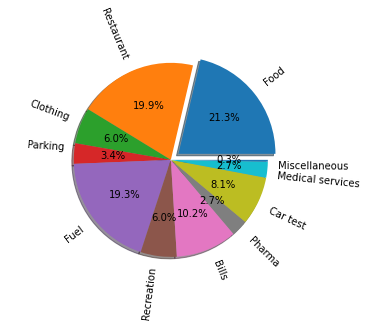

In [21]:
Geller.pieChart()

**Analysis for purchases per day**

I created a new class- called Day, which gets the day name (e.g., Sun, Mon...) and the data list (i.e., the data from Family class- with or without name). However, within the class another filter is made and takes the relevant data for the given day.

That class has two methods:

1- purch_byDay_dict- similar to the purchase method of Family class, return the dictionary (not printing anything)

2- max_purch- calls the purch_byDay_dict and returns the maximum value of money spent and its category (Family class calls that method).

In [23]:
class Day:
  def __init__(self, day_name, data_list):
    self.data_list=data_list
    self.dayName=day_name
    self.data_by_day=[]

    for purchase in self.data_list:
      if purchase[6]==self.dayName:
           self.data_by_day.append(purchase)

  def purch_byDay_dict(self):
    self.shops_dict={}                        # type:[[shop_name],[amount],[num]]
    for purchase in self.data_by_day:
      if purchase[3] not in self.shops_dict:  #If type of shopping does not exist-->create
        self.shops_dict[purchase[3]]= [[purchase[2]],[purchase[4]],[1]]
      else:
        if purchase[2] in self.shops_dict[purchase[3]][0]: # If shop_name also exist
          ind= self.shops_dict[purchase[3]][0].index(purchase[2])
          self.shops_dict[purchase[3]][1][ind] += purchase[4]
          self.shops_dict[purchase[3]][2][ind] += 1
        else: 
          self.shops_dict[purchase[3]][0].append(purchase[2])
          self.shops_dict[purchase[3]][1].append(purchase[4])
          self.shops_dict[purchase[3]][2].append(1)
    return self.shops_dict

  def max_purch(self):
    self.purch_dict=self.purch_byDay_dict()
    purch_list=[(sum(self.purch_dict[key][1]),key) for key in self.purch_dict]
    max_val= list(sorted(purch_list, key= lambda x: x[0], reverse= True))
    return max_val[0]

In [24]:
Geller.byDay()

+-----------+---------------------+------------+
|    Day    | Highest Amount(NIS) |  Category  |
+-----------+---------------------+------------+
|   Sunday  |        829.23       |    Fuel    |
|   Monday  |        289.0        | Recreation |
|  Tuesday  |       2467.69       |    Food    |
| Wedensday |        673.0        |    Food    |
|  Thursday |        621.0        |   Bills    |
|   Friday  |       1403.76       |    Fuel    |
|  Saterday |        726.0        | Restaurant |
+-----------+---------------------+------------+


**Analysis for purchases per month**

That graph shows the total expenditures per month.

Note: Feb is not over yet


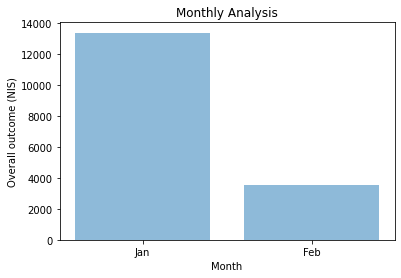

In [25]:
Geller.byMonth()

***Methods for analysing data***

NOTE: This method requires a budget, you will get an error otherwise.

The main goal of that section is to conclude few tips to help the user save money. Specifically, method 7 (called "tips") calls method 8 ("savings") if the budget was exceeded. Of course, the user can also call "savings" if he wishes (even if he stayed within the budget).

In [26]:
Geller.tips()

Oops, no budget was given. Please define Family object again and insert budget.




> I told you so...



In [27]:
Geller= Family('Geller.db',budget=5000)
Geller.tips()

Oh, you exceeded your badget...

In Food category you had the highest amount of spending in "Rami Cohen" store
	with average spending of 617.33 NIS per visit, which is 68.35% higher from the total 
	average of money spent in this category.
	You should consider buy more in "Bakery and more" store instead, which is cheaper.

In Restaurant category you had the highest amount of spending in "Best Burger" store
	with average spending of 213.50 NIS per visit, which is 187.37% higher from the total 
	average of money spent in this category.
	You should consider buy more in "Coffee and Cake" store instead, which is cheaper.

In Parking category you had the highest amount of spending in "Sea Parking" store
	with average spending of 35.00 NIS per visit, which is 50.00% higher from the total 
	average of money spent in this category.
	You should consider buy more in "Monica's Parking" store instead, which is cheaper.

In Fuel category you had the highest amount of spending in "So Fuel" store
	wit



> Let's run all the mehods again but ask for personal-level analysis:




From 2020-01-02 to 2020-02-12 you spent total of 6491.63 NIS:
+------------+--------------------+
|  Category  | Amount spent (NIS) |
+------------+--------------------+
|    Food    |       298.74       |
|    Fuel    |      1680.59       |
| Restaurant |       2554.5       |
|  Parking   |        35.0        |
|   Bills    |       329.8        |
|  Car test  |       1369.0       |
| Recreation |       224.0        |
+------------+--------------------+


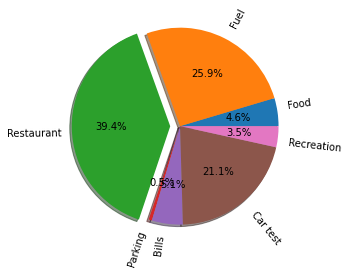

+-----------+---------------------+------------+
|    Day    | Highest Amount(NIS) |  Category  |
+-----------+---------------------+------------+
|   Sunday  |        343.0        | Restaurant |
|   Monday  |        263.23       |    Fuel    |
|  Tuesday  |        1369.0       |  Car test  |
| Wedensday |        270.0        |    Fuel    |
|  Thursday |        301.0        | Restaurant |
|   Friday  |        854.5        | Restaurant |
|  Saterday |        460.0        | Restaurant |
+-----------+---------------------+------------+
Note: Feb is not over yet


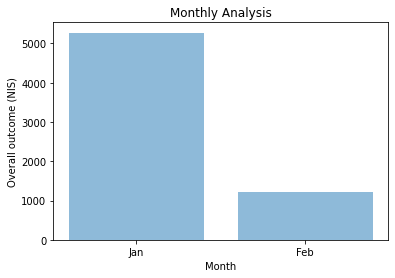

Well done! You did not exceed your budget!
Here are some of your purchases:
From 2020-01-02 to 2020-02-12 you spent total of 6491.63 NIS:
+------------+--------------------+
|  Category  | Amount spent (NIS) |
+------------+--------------------+
|    Food    |       298.74       |
|    Fuel    |      1680.59       |
| Restaurant |       2554.5       |
|  Parking   |        35.0        |
|   Bills    |       329.8        |
|  Car test  |       1369.0       |
| Recreation |       224.0        |
+------------+--------------------+


In [28]:
Geller= Family('Geller.db',budget=15000, name='Ross')

Geller.purchases()
Geller.pieChart()
Geller.byDay()
Geller.byMonth()

Geller.tips() # An example for not exceeding budget

### **THANK YOU :)**